# Imports #

In [524]:
from os import walk
import pandas as pd 
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from PIL import Image , ImageOps

from bs4 import BeautifulSoup

%matplotlib inline

# Constants #

In [567]:
Example_file = "SpamData/SpamData/01_Processing/practice_email.txt"
Easy_ham_01 = "SpamData/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1"
Easy_ham_02 = "SpamData/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2"
Spam_01 = "SpamData/SpamData/01_Processing/spam_assassin_corpus/spam_1"
Spam_02 = "SpamData/SpamData/01_Processing/spam_assassin_corpus/spam_2"


WORD_ID_FILE = "SpamData/SpamData/01_Processing/word-by-id.csv"
DATA_JSON_FILE = "SpamData/SpamData/01_Processing/email-text-data.json"
TRAIN_DATA_FILE = 'SpamData/SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/SpamData/02_Training/test-data.txt'

VOCAB_SIZE = 2500

SPAM_ICON = "C:/Users/IsarShmueli/Desktop/ML_projects/SpamData/SpamData/01_Processing/wordcloud_resources/thumbs-down.png"
HAM_ICON = "C:/Users/IsarShmueli/Desktop/ML_projects/SpamData/SpamData/01_Processing/wordcloud_resources/thumbs-up.png"

# Reading file #

In [461]:
stream = open(Example_file, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)




# Email extraction

In [462]:
def email_body_extraction(path):
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            file_path = join(root, file_name)
            
            stream = open(file_path, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body

In [463]:
def df_from_directory(path, classification):
    rows = []
    rows_names = []
    for file_name, email_body in email_body_extraction(path):
        rows.append({"Message" : email_body, 'Category' : classification})
        rows_names.append(file_name)
        
    return pd.DataFrame(rows, index=rows_names)

In [464]:
spam_emails = df_from_directory(Spam_01,classification=1)
spam_emails = pd.concat([spam_emails, df_from_directory(Spam_02, 1)])

In [465]:
ham_emails = df_from_directory(Easy_ham_01, classification=0)
ham_emails = pd.concat([ham_emails, df_from_directory(Easy_ham_02, classification=0)])

In [466]:
data = pd.concat([spam_emails, ham_emails])
data['Message'].isnull().values.any()
data[data['Message'].str.len() == 0].index
data.drop(['cmds'], inplace = True)

documnets_ids = range(0, 5796)
data['DOC_IDS'] = document_ids
data['DOC_NAMES'] = data.index
data.set_index('DOC_IDS', inplace=True)



In [467]:
documnets_ids = range(0, 5796)
data['DOC_IDS'] = document_ids
data['DOC_NAMES'] = data.index
data.set_index('DOC_IDS', inplace=True)
data.to_json(DATA_JSON_FILE)


In [468]:
data.Category.value_counts()

amount_of_spam = data.Category.value_counts()[1]
amount_of_ham = data.Category.value_counts()[0]

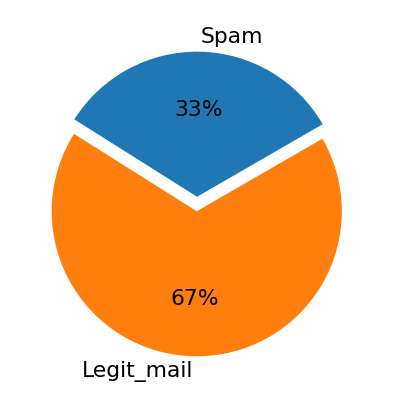

In [469]:
category_names = ['Spam', 'Legit_mail']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(3,3), dpi = 157)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 10}, startangle=30,
       autopct='%1.0f%%',explode=[0,0.1])
plt.show()

# NLP

## text-preprocessing

In [470]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\IsarShmueli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\IsarShmueli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Cleaning the email  function

In [471]:
def clean_message(message, stermmer=PorterStemmer(), stop_words=set(stopwords.words('english'))):
    filtered_words = []
    
    soup = BeautifulSoup(message, 'html.parser')
    clean_text = soup.get_text()
    
    words = word_tokenize(clean_text.lower())
    for word in words:
        if word not in stop_words and word.isalpha():
            stemed_word = stemmer.stem(word)
            filtered_words.append(stemed_word)
    
    return filtered_words
    
    
        

In [472]:
nested_list = data.Message.apply(clean_message)

ham_doc_ids = data[data.Category == 0].index
spam_doc_ids = data[data.Category == 1].index

nested_list_spam = nested_list.loc[spam_doc_ids]
nested_list_ham = nested_list.loc[ham_doc_ids]

C:\Users\IsarShmueli\AppData\Local\Temp\ipykernel_5736\4059427222.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')
C:\Users\IsarShmueli\AppData\Local\Temp\ipykernel_5736\4059427222.py:4: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')


# visualizing the words

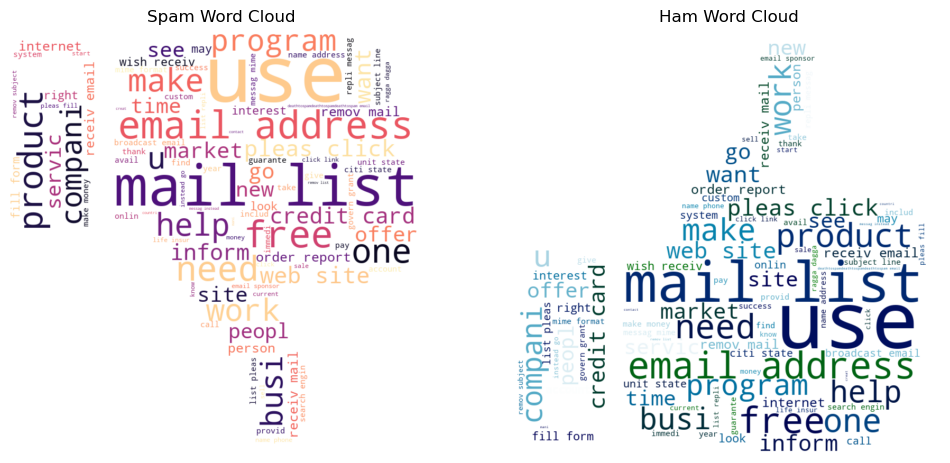

In [473]:
### creating a single list ###
flat_spam_list = [item for listt in nested_list_spam for item in listt]
flat_ham_list = [item for listt in nested_list_ham for item in listt]

spam_words = pd.Series(flat_spam_list)
normal_words = pd.Series(flat_ham_list)

normal_words.value_counts()[0:10]
spam_words.value_counts()[0:10]

spam_as_string = " ".join(flat_spam_list)
ham_as_string = " ".join(flat_spam_list)


## word clouds presentation ###


##spam
spam_icon = Image.open(SPAM_ICON).convert('RGBA')
spam_icon = spam_icon.resize((800,800))
image_mask_spam = Image.new(mode='RGB', size=spam_icon.size, color=(255,255,255))
image_mask_spam.paste(spam_icon, box=spam_icon)
rgb_array_spam = np.array(image_mask_spam)


## ham 
ham_icon = Image.open(HAM_ICON).convert('RGBA')
ham_icon = ham_icon.resize((800,800))
image_mask_ham = Image.new(mode='RGB', size=ham_icon.size, color=(255,255,255))
image_mask_ham.paste(ham_icon, box=ham_icon)
rgb_array_ham = np.array(image_mask_ham)



spam_wordcloud = WordCloud(mask=rgb_array_spam, background_color='white',colormap='magma',max_words=2000).generate(spam_as_string)
ham_wordcloud = WordCloud(mask=rgb_array_ham, background_color='white',colormap='ocean',max_words=2000).generate(ham_as_string)

fig, axes = plt.subplots(1, 2, figsize=(12, 15))

# spam word cloud
axes[0].imshow(spam_wordcloud, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Spam Word Cloud')

# ham word cloud
axes[1].imshow(ham_wordcloud, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Ham Word Cloud')


plt.show()

# Generate vocabulary & dict 

In [475]:
stemmed_nested_list = data.Message.apply(clean_message)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

C:\Users\IsarShmueli\AppData\Local\Temp\ipykernel_5736\4059427222.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')
C:\Users\IsarShmueli\AppData\Local\Temp\ipykernel_5736\4059427222.py:4: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')


In [571]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
frequent_words = unique_words[:VOCAB_SIZE]

## creat a dataframe for the words

word_ids = list(range(0,VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index},index = word_ids)
vocab.index.name = 'WORD_ID' 


## Creating csv for the vocabulary

In [492]:
vocab.to_csv(WORD_ID_FILE, index_label = vocab.index.name, header = vocab.VOCAB_WORD.name)

In [525]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.to_list())

x_train, x_test, y_train, y_test = train_test_split(word_columns_df, data.Category,
                                                   test_size=0.3, random_state=42)


In [545]:
x_test.index.name = x_train.index.name = 'DOC_ID'
word_index = pd.Index(vocab.VOCAB_WORD)

## making a sparse matrix 

In [546]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as a DataFrame.
    
    df: a DataFrame with words as columns and doc_ids as index (x_train/x_test)
    indexed_words: index of words ordered by word id 
    labels: category as a series (y_train/y_test)
    """
    
    nr_rows = df.shape[0]
    nr_columns = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_columns):
            
            word = df.iat[i, j]
            if word in word_set:
                
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
                
                
    return pd.DataFrame(dict_list)
                
    

In [569]:
%%time

sparse_train_df = make_sparse_matrix(df=x_train, indexed_words=word_index, labels=y_train)
sparse_test_df = make_sparse_matrix(df=x_test, indexed_words=word_index, labels=y_test)

CPU times: total: 5min 9s
Wall time: 9min


In [570]:
#train
grouped_train_df = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
grouped_train_df = grouped_train_df.reset_index()

np.savetxt(fname=TRAIN_DATA_FILE,X=grouped_train_df,fmt='%d')

###

#test
grouped_test_df = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
grouped_test_df = grouped_test_df.reset_index()

np.savetxt(fname=TEST_DATA_FILE,X=grouped_test_df,fmt='%d')